In [47]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patheffects as path_effects
import matplotlib.transforms as transforms
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface,
                                HeliocentricEarthEcliptic, get_body_heliographic_stonyhurst)
import sunkit_image
import sunkit_image.coalignment as coalignment
import sunkit_image.trace as trace
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
import eispac
import irispy.io
import pyvista as pv
import h5py
from scipy.interpolate import LinearNDInterpolator
from scipy.io import readsav
import cv2
from watroo import wow, Triangle, denoise

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, MaxNLocator,
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize,PowerStretch)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   

plt.rcParams['font.family'] = "serif"
plt.rcParams['font.sans-serif'] = "Comic Sans MS"
plt.rcParams['image.interpolation'] = "nearest"
plt.rcParams["mathtext.default"] = "sf"




In [48]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1),orientation="vertical"):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [49]:
# VBI image from Tom's png files, will be replaced by real VBI data in the future
from PIL import Image

vbi_CaIIK = np.asarray(Image.open("../../figs/DKIST_png_Tom/dkist_vbiBlue_CaIIK_393_20221024_190152(1).png"))


In [50]:
hri_174_map = sunpy.map.Map("../../src/coalign_map/20221024/hri_174_map_shifted_toaia.fits")

In [51]:
aia_1600_map = sunpy.map.Map("../../src/AIA/20221024/1600/lvl15/aia.lev1_uv_24s.2022-10-24T190151Z.1600.image.fits")
aia_1600_crop = aia_1600_map.submap(SkyCoord(-430*u.arcsec, 165*u.arcsec, frame=aia_1600_map.coordinate_frame),
                                    top_right=SkyCoord(-370*u.arcsec, 230*u.arcsec, frame=aia_1600_map.coordinate_frame))

In [52]:
aia_1600_map_eui_time = sunpy.map.Map("../../src/AIA/20221024/1600/lvl15/aia.lev1_uv_24s.2022-10-24T191951Z.1600.image.fits")

In [53]:
vbi_fake_Tx, vbi_fake_Ty = np.array([-397.77777777777777, 198.08641975308643,
-393.88888888888886, 193.0246913580247,
-393.39506172839504, 185.12345679012344,
-389.69135802469134, 191.97530864197532,
-385.8024691358024, 194.44444444444446,
-382.8395061728395, 198.0246913580247,
-381.7283950617284, 203.76543209876544,
-379.9382716049382, 210.06172839506172,
-383.82716049382714, 206.97530864197532,
-389.5061728395062, 206.17283950617283,
-394.75308641975306, 206.79012345679013,
-402.22222222222223, 207.65432098765433,
-406.41975308641975, 205.1851851851852,
-401.66666666666663, 200.55555555555557]).reshape(-1,2).T

vbi_fake_Tx = vbi_fake_Tx + 4.5
vbi_fake_Ty = vbi_fake_Ty + 1.0

vbi_fake_contour_coords = SkyCoord(vbi_fake_Tx*u.arcsec, vbi_fake_Ty*u.arcsec, frame="helioprojective", observer="earth", obstime=Time("2022-10-24T19:01:52"))

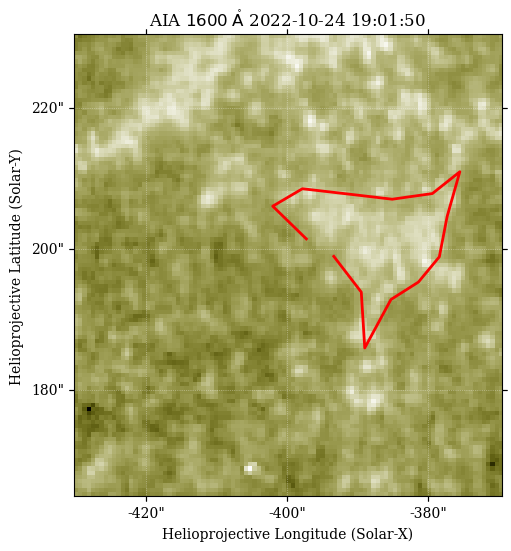

In [54]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=aia_1600_crop)
aia_1600_crop.plot(axes=ax)

with propagate_with_solar_surface(rotation_model="rigid"):
    ax.plot_coord(vbi_fake_contour_coords, color="r", lw=2)

In [55]:
vbi_bottom_left = -418.58024691358025 + 4.5, 175.80246913580248 + 1.0
vbi_top_right = -375.4938271604938 + 4.5, 219.7530864197531 + 1.0
vbi_bottom_right = -375.4938271604938 + 4.5, 175.80246913580248 + 1.0
vbi_bottom_left_coord = SkyCoord(vbi_bottom_left[0]*u.arcsec, vbi_bottom_left[1]*u.arcsec, frame="helioprojective", observer="earth", obstime=Time("2022-10-24T19:01:52"))
vbi_top_right_coord = SkyCoord(vbi_top_right[0]*u.arcsec, vbi_top_right[1]*u.arcsec, frame="helioprojective", observer="earth", obstime=Time("2022-10-24T19:01:52"))
vbi_bottom_right_coord = SkyCoord(vbi_bottom_right[0]*u.arcsec, vbi_bottom_right[1]*u.arcsec, frame="helioprojective", observer="earth", obstime=Time("2022-10-24T19:01:52"))

In [56]:
with propagate_with_solar_surface(rotation_model="rigid"):
    vbi_bottom_left_coord_in_hri = vbi_bottom_left_coord.transform_to(hri_174_map.coordinate_frame)
    vbi_top_right_coord_in_hri = vbi_top_right_coord.transform_to(hri_174_map.coordinate_frame)
    vbi_bottom_right_coord_in_hri = vbi_bottom_right_coord.transform_to(hri_174_map.coordinate_frame)

In [57]:
cryo_NIRSP_1074 = np.asarray(Image.open("../../figs/DKIST_png_Tom/fe1075_maps_20Oct_1854UT_crop.png"))

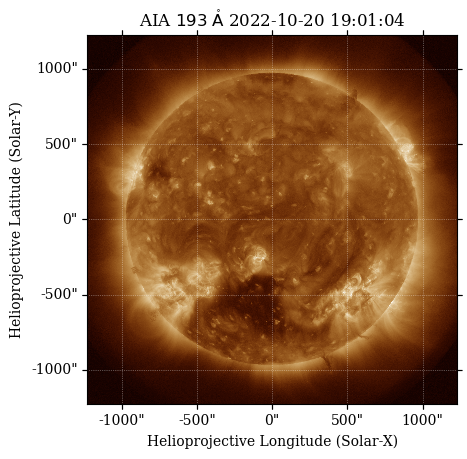

In [58]:
aia_193_map = sunpy.map.Map("../../src/AIA/20221020/193/lvl15/aia.lev1_euv_12s.2022-10-20T190103Z.193.image.fits")
aia_193_map.plot()

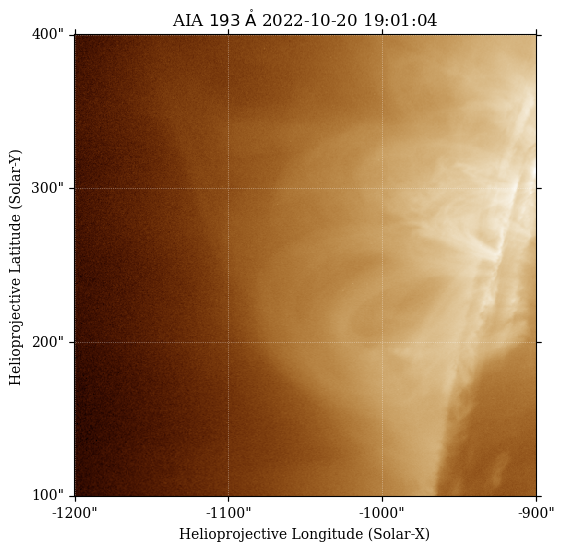

In [59]:
# aia_193_map = sunpy.map.Map("../../src/AIA/20221019/193/lvl15/aia.lev1_euv_12s.2022-10-19T191515Z.193.image.fits")

aia_193_map_crop = aia_193_map.submap(SkyCoord(-1200*u.arcsec, 100*u.arcsec, frame=aia_193_map.coordinate_frame),
                                    top_right=SkyCoord(-900*u.arcsec, 400*u.arcsec, frame=aia_193_map.coordinate_frame))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=aia_193_map_crop)
aia_193_map_crop.plot(axes=ax)

In [60]:
with fits.open("../../src/AIA/20221020/193/lvl15/AIA20221020_190105_193_rfilter.fits") as hdul:
    aia_193_data_rfilter = hdul[0].data.copy()
    aia_193_rfilter_map = sunpy.map.Map(aia_193_data_rfilter, aia_193_map.meta)
aia_193_rfilter_map_crop = aia_193_rfilter_map.submap(SkyCoord(-1200*u.arcsec, 100*u.arcsec, frame=aia_193_rfilter_map.coordinate_frame),
                                    top_right=SkyCoord(-900*u.arcsec, 400*u.arcsec, frame=aia_193_rfilter_map.coordinate_frame))
aia_193_rfilter_map_crop.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=200)

(<matplotlib.patches.Circle at 0x7fed232ef650>, None)

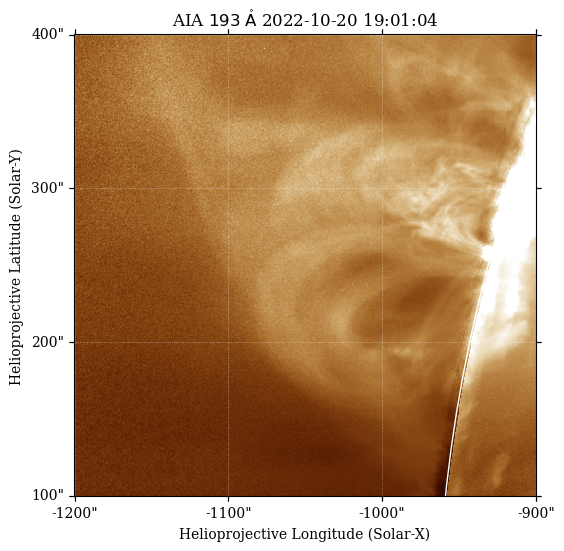

In [61]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=aia_193_rfilter_map_crop)
aia_193_rfilter_map_crop.plot(axes=ax)
aia_193_rfilter_map_crop.draw_limb(axes=ax)

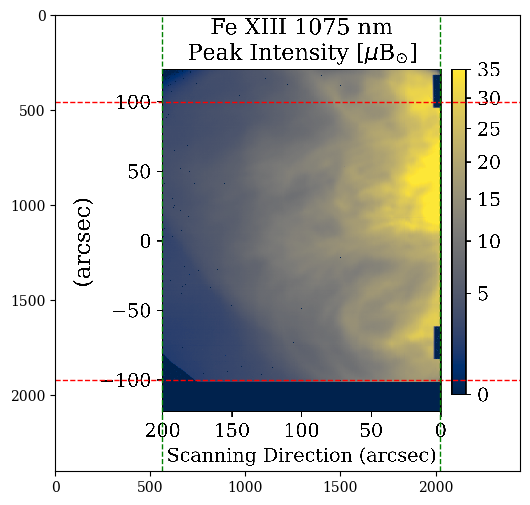

In [62]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cryo_NIRSP_1074)
ax.axhline(459, color="r", lw=1,ls="--")
ax.axhline(1921, color="r", lw=1,ls="--")
ax.axvline(563,color="green",lw=1,ls="--")
ax.axvline(2025,color="green",lw=1,ls="--")
plt.savefig("../../figs/test_figs/cryo_nirsp_fake", dpi=300, bbox_inches="tight")

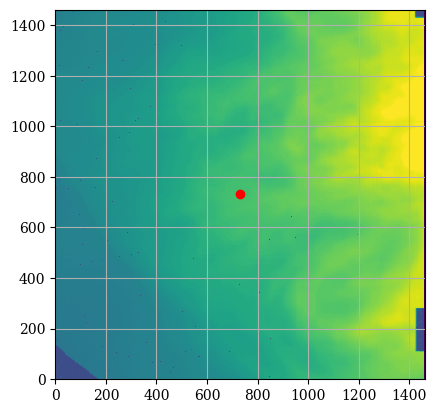

In [63]:
cryo_NIRSP_1074_data = np.flip(cryo_NIRSP_1074[459:1921,563:2025], axis=0)
cryo_NIRSP_1074_data = cv2.cvtColor(cryo_NIRSP_1074_data, cv2.COLOR_BGR2GRAY)
plt.imshow(cryo_NIRSP_1074_data, origin="lower")
plt.grid("on")
plt.scatter(cryo_NIRSP_1074_data.shape[1]//2, cryo_NIRSP_1074_data.shape[0]//2, color="r")
plt.savefig("../../figs/test_figs/cryo_nirsp_fake_data.png", dpi=300, bbox_inches="tight")

In [64]:
def rfilter_map(map):
    hpc_coords = sunpy.map.all_coordinates_from_map(map)
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / map.rsun_obs
    rsun_step_size = 0.01
    rsun_array = np.arange(1.05, r.max(), rsun_step_size)
    y = np.array([map.data[(r > this_r) * (r < this_r + rsun_step_size)].mean()
                for this_r in rsun_array])
    params = np.polyfit(rsun_array[(rsun_array>1.05)&(rsun_array<1.2)],
                    np.log(y[(rsun_array>1.05)&(rsun_array<1.2)]), 1)

    # fig, ax = plt.subplots()

    # ax.plot(rsun_array, y, label='data')
    # best_fit = np.exp(np.poly1d(params)(rsun_array))
    # ax.plot(rsun_array, best_fit)


    # print(params)
    scale_factor = np.exp((r-1)*-params[0])
    scale_factor[r < 1] = 1

    scaled_map = sunpy.map.Map(map.data * scale_factor, map.meta)
    # scaled_map.plot_settings['norm'] = ImageNormalize(stretch=map.plot_settings['norm'].stretch)

    return scaled_map



In [65]:
np.arcsin(250*u.arcsec/aia_193_map.rsun_obs).to(u.deg)

<Quantity 15.03142948 deg>

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = super().contour(*args, **kwargs)


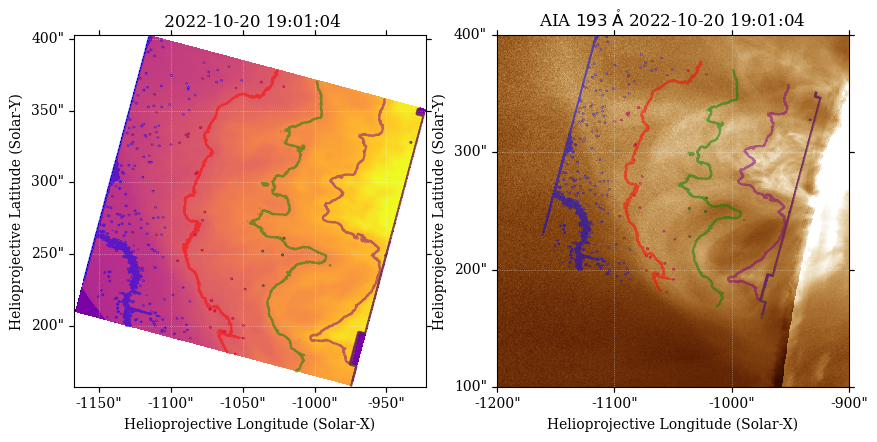

In [66]:
cryo_NIRSP_fake_wcs_header = sunpy.map.make_fitswcs_header(cryo_NIRSP_1074_data, 
                                                SkyCoord(-1045*u.arcsec, 280*u.arcsec, frame=aia_193_map.coordinate_frame),
                                                scale = u.Quantity((200./cryo_NIRSP_1074_data.shape[1],
                                                         200./cryo_NIRSP_1074_data.shape[0]), u.arcsec/u.pix),
                                                rotation_angle=-15*u.deg,
                                                instrument="CryoNIRSP",
                                                telescope="DKIST")
norm_cryo_NIRSP_1074 = ImageNormalize()
cryo_NIRSP_1074_map = sunpy.map.Map(norm_cryo_NIRSP_1074(cryo_NIRSP_1074_data.astype(np.float64))*35, cryo_NIRSP_fake_wcs_header)
cryo_NIRSP_1074_map_rotate = cryo_NIRSP_1074_map.rotate()
cryo_NIRSP_1074_map_rfilter = rfilter_map(cryo_NIRSP_1074_map)
cryo_NIRSP_1074_map_rfilter_rotate = cryo_NIRSP_1074_map_rfilter.rotate()



fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(121, projection=cryo_NIRSP_1074_map_rotate)
cryo_NIRSP_1074_map_rotate.plot(axes=ax1,cmap="plasma",vmin=0,vmax=35)
# plt.colorbar()

ax2 = fig.add_subplot(122, projection=aia_193_rfilter_map_crop)
aia_193_rfilter_map_crop.plot(axes=ax2)

for ax_ in (ax1, ax2):
    bounds = ax_.axis()
    cryo_NIRSP_1074_map_rotate.draw_contours(axes=ax_, levels=[15,20,25,30], colors=["b","r","green","purple"], lw=0.5,alpha=0.5)
    ax_.axis(bounds)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = super().contour(*args, **kwargs)


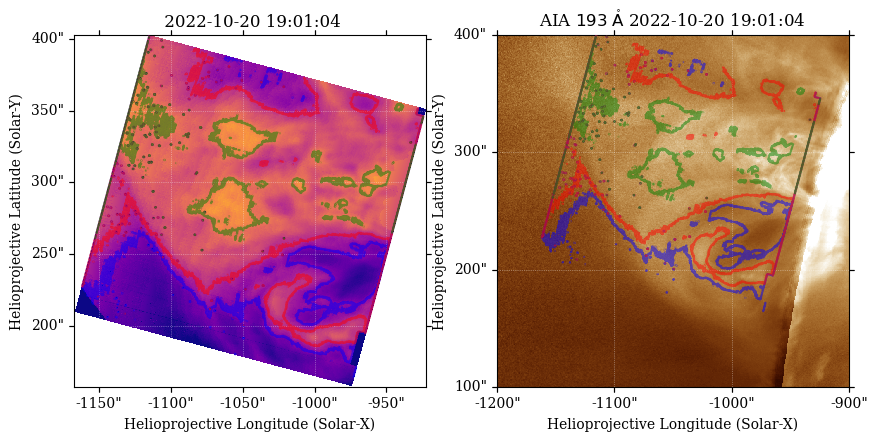

In [67]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(121, projection=cryo_NIRSP_1074_map_rfilter_rotate)
cryo_NIRSP_1074_map_rfilter_rotate.plot(axes=ax1,cmap="plasma",vmin=30,vmax=45)
# plt.colorbar()

ax2 = fig.add_subplot(122, projection=aia_193_rfilter_map_crop)
aia_193_rfilter_map_crop.plot(axes=ax2)

for ax_ in (ax1, ax2):
    bounds = ax_.axis()
    cryo_NIRSP_1074_map_rfilter_rotate.draw_contours(axes=ax_, levels=[34,36,40,42], colors=["b","r","green","purple"], lw=0.5,alpha=0.5)
    ax_.axis(bounds)

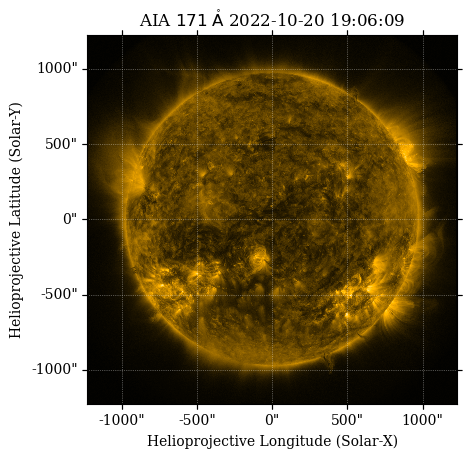

In [68]:
aia_171_map = sunpy.map.Map("../../src/AIA/20221020/171/lvl15/aia.lev1_euv_12s.2022-10-20T190615Z.171.image.fits")
aia_171_map.plot()

In [69]:
aia_171_map_crop = aia_171_map.submap(SkyCoord(-1200*u.arcsec, 100*u.arcsec, frame=aia_171_map.coordinate_frame),
                                    top_right=SkyCoord(-800*u.arcsec, 450*u.arcsec, frame=aia_171_map.coordinate_frame))


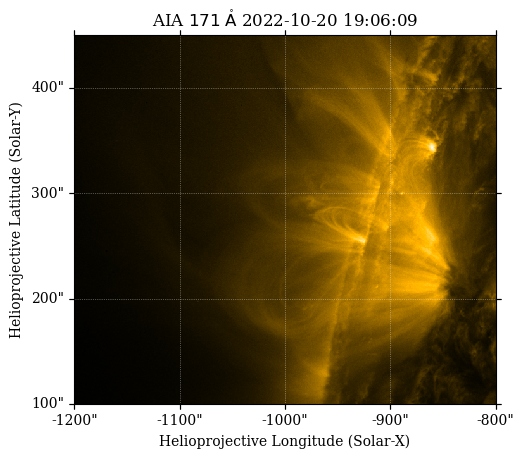

In [70]:
aia_171_map_crop.plot(norm=ImageNormalize(stretch=AsinhStretch(0.5)))

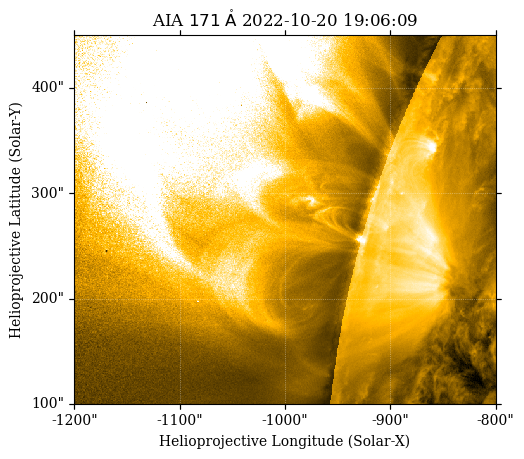

In [71]:
with fits.open("../../src/AIA/20221020/171/lvl15/AIA20221020_190609_171.fits") as hdul:
    aia_171_data_rfilter = hdul[0].data.copy()
    aia_171_rfilter_map = sunpy.map.Map(aia_171_data_rfilter, aia_171_map.meta)
aia_171_rfilter_map_crop = aia_171_rfilter_map.submap(SkyCoord(-1200*u.arcsec, 100*u.arcsec, frame=aia_171_rfilter_map.coordinate_frame),
                                    top_right=SkyCoord(-800*u.arcsec, 450*u.arcsec, frame=aia_171_rfilter_map.coordinate_frame))
aia_171_rfilter_map_crop.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=200)
aia_171_rfilter_map_crop.plot()

In [72]:
with sunpy.coordinates.Helioprojective.assume_spherical_screen(aia_193_rfilter_map.observer_coordinate, only_off_disk=True):
    SunBlinker(aia_193_rfilter_map_crop, aia_171_rfilter_map_crop,reproject=True)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = super().contour(*args, **kwargs)


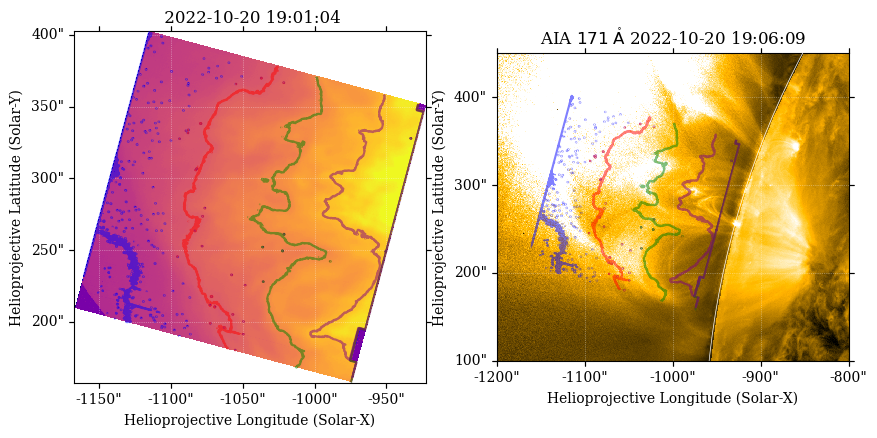

In [73]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(121, projection=cryo_NIRSP_1074_map_rotate)
cryo_NIRSP_1074_map_rotate.plot(axes=ax1,cmap="plasma",vmin=0,vmax=35)
# plt.colorbar()

ax2 = fig.add_subplot(122, projection=aia_171_rfilter_map_crop)
aia_171_rfilter_map_crop.plot(axes=ax2)
aia_171_rfilter_map_crop.draw_limb(color="w",lw=0.5,axes=ax2)

for ax_ in (ax1, ax2):
    bounds = ax_.axis()
    with sunpy.coordinates.Helioprojective.assume_spherical_screen(aia_171_rfilter_map_crop.observer_coordinate,only_off_disk=True):
        cryo_NIRSP_1074_map_rotate.draw_contours(axes=ax_, levels=[15,20,25,30], colors=["b","r","green","purple"], lw=0.5,alpha=0.5)
    ax_.axis(bounds)

In [74]:
def find_fake_aia_pos(coords_aia_to_fsi, aia_map, fsi_map):
    aia_coord_hee = aia_map.observer_coordinate.transform_to(fsi_map.observer_coordinate)
    aia_coord_hee_xyz = aia_coord_hee.cartesian.xyz

    coords_aia_to_fsi_hee = coords_aia_to_fsi.transform_to(fsi_map.observer_coordinate)
    coords_aia_to_fsi_hee_xyz = coords_aia_to_fsi_hee.cartesian.xyz

    fake_aia_hee_xyz = aia_coord_hee_xyz*0.005 + coords_aia_to_fsi_hee_xyz*0.995
    fake_aia_hee_coord = SkyCoord(*fake_aia_hee_xyz,frame=fsi_map.observer_coordinate,representation_type="cartesian")
    
    fake_aia_coord = fake_aia_hee_coord.transform_to(fsi_map.coordinate_frame)

    return fake_aia_coord

In [75]:
def find_nearest_point(xyz11,xyz12,xyz21,xyz22):
    v1 = xyz12 - xyz11
    v2 = xyz22 - xyz21

    norm_v1_v2 = np.cross(v1,v2)
    norm_v1_v2 = norm_v1_v2

    nearest_distance = np.dot(xyz11-xyz21,norm_v1_v2)/np.linalg.norm(norm_v1_v2)

    t1_to_nearest = np.dot(np.cross(v2,norm_v1_v2),xyz21-xyz11)/np.linalg.norm(norm_v1_v2)**2
    t2_to_nearest = np.dot(np.cross(v1,norm_v1_v2),xyz21-xyz11)/np.linalg.norm(norm_v1_v2)**2

    xyz1_nearest = xyz11 + t1_to_nearest*v1
    xyz2_nearest = xyz21 + t2_to_nearest*v2

    middle_point = (xyz1_nearest + xyz2_nearest)/2

    return middle_point

In [76]:
def find_most_probable_hee_coord(aia_map, fsi_map, coord_aia, coord_fsi):
    aia_coord_hee = aia_map.observer_coordinate.transform_to(fsi_map.observer_coordinate)
    aia_coord_hee_xyz = aia_coord_hee.cartesian.xyz

    with propagate_with_solar_surface(rotation_model="rigid"):
        coord_aia_hee = coord_aia.transform_to(fsi_map.observer_coordinate)
    
    coord_aia_hee_xyz = coord_aia_hee.cartesian.xyz

    solar_orbiter_hee = fsi_map.observer_coordinate
    solar_orbiter_hee_xyz = solar_orbiter_hee.cartesian.xyz

    coord_fsi_hee = coord_fsi.transform_to(fsi_map.observer_coordinate)
    coord_fsi_hee_xyz = coord_fsi_hee.cartesian.xyz

    probable_coord_hee_xyz = find_nearest_point(aia_coord_hee_xyz,coord_aia_hee_xyz,
                            solar_orbiter_hee_xyz,coord_fsi_hee_xyz)
    
    probable_coord_hee_coord = SkyCoord(*probable_coord_hee_xyz,frame=fsi_map.observer_coordinate,
                            representation_type="cartesian")

    return probable_coord_hee_coord

In [77]:
def get_y_on_line(x, x1, y1, x2, y2):
    return (x - x1) * (y2 - y1) / (x2 - x1) + y1

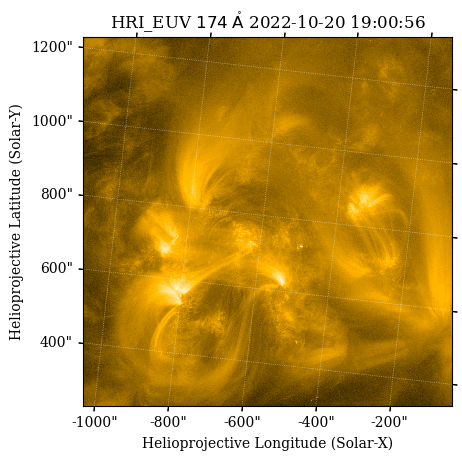

In [78]:
hri_174_map_1020 = sunpy.map.Map("../../src/coalign_map/20221020/hri_174_map_shift_1900.fits")
hri_174_map_1020.plot()

In [79]:
hri_174_map_1020_rebin = hri_174_map_1020.resample((hri_174_map_1020.data.shape[1]//4,hri_174_map_1020.data.shape[0]//4)*u.pix)

In [80]:
loops_hri = trace.occult2(hri_174_map_1020_rebin.data, nsm1=9, rmin=30, lmin=25, nstruc=1000, ngap=3, qthresh1=0.0, qthresh2=3.0)

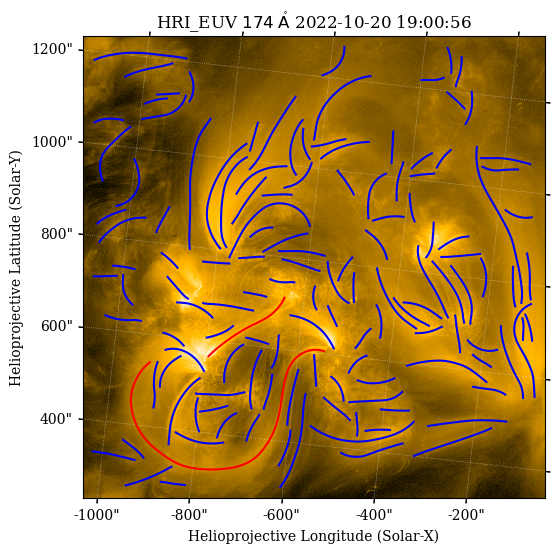

In [81]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=hri_174_map_1020_rebin)
hri_174_map_1020_rebin.plot(axes=ax)
for ii, loop_ in enumerate(loops_hri):
    loop_ = np.array(loop_)  # convert to array as easier to index `x` and `y` coordinates
    coord_loops = hri_174_map_1020_rebin.pixel_to_world(loop_[:, 0] * u.pixel, loop_[:, 1] * u.pixel)
    if ii == 1 or ii == 12:
        ax.plot_coord(coord_loops, color="r")
    else:
        ax.plot_coord(coord_loops, color="b")


In [82]:
longest_loop_index = 0
longest_loop_length = 0
for ii, loop_ in enumerate(loops_hri):
    loop_ = np.array(loop_) 
    loop_length = loop_.shape[0]
    if loop_length > longest_loop_length:
        longest_loop_length = loop_length
        longest_loop_index = ii


print(longest_loop_index, longest_loop_length)


12 387


In [83]:
longest_loop_coord = hri_174_map_1020_rebin.pixel_to_world(np.asarray(loops_hri[longest_loop_index])[:, 0] * u.pixel, np.asarray(loops_hri[longest_loop_index])[:, 1] * u.pixel)
loop_1_coord = hri_174_map_1020_rebin.pixel_to_world(np.asarray(loops_hri[1])[:, 0] * u.pixel, np.asarray(loops_hri[1])[:, 1] * u.pixel)

In [84]:
longest_loop_coord_simple = longest_loop_coord[20:-80:40]
loop_1_coord_simple = loop_1_coord[10::30]
loop_1_coord_simple[0] = SkyCoord(loop_1_coord_simple[0].Tx, loop_1_coord_simple[0].Ty-10*u.arcsec, frame=loop_1_coord_simple[0].frame)

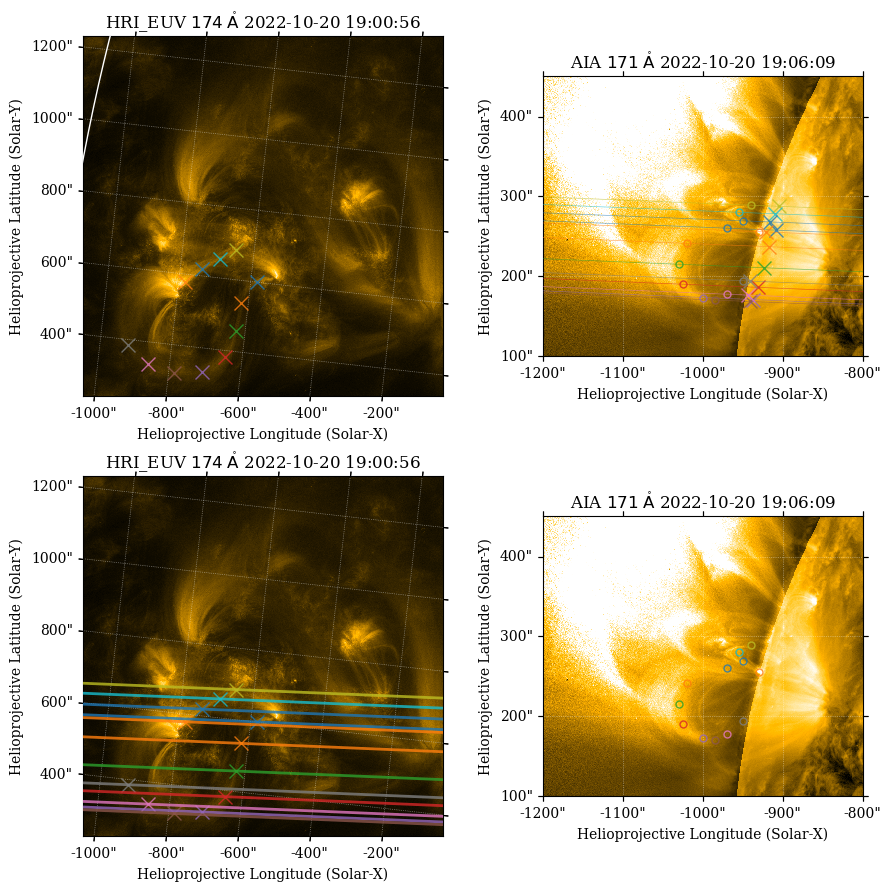

In [85]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_axes([0,0.55,0.6,0.45],projection=hri_174_map_1020)
hri_174_map_1020.plot(axes=ax1,norm=ImageNormalize(stretch=AsinhStretch(0.15)))

ax2 = fig.add_axes([0.65,0.55,0.4,0.45],projection=aia_171_rfilter_map_crop)
aia_171_rfilter_map_crop.plot(axes=ax2)

ax3 = fig.add_axes([0,0,0.6,0.45],projection=hri_174_map_1020)
hri_174_map_1020.plot(axes=ax3,norm=ImageNormalize(stretch=AsinhStretch(0.15)))

ax4 = fig.add_axes([0.65,0,0.4,0.45],projection=aia_171_rfilter_map_crop)
aia_171_rfilter_map_crop.plot(axes=ax4)

with propagate_with_solar_surface(rotation_model="rigid"):
    aia_171_rfilter_map_crop.draw_limb(axes=ax1)

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = color_cycle + color_cycle[:2]

solar_orbiter_aia = hri_174_map_1020.observer_coordinate.transform_to(aia_171_rfilter_map_crop.coordinate_frame)

# Tx_coord_hri, Ty_coord_hri = (-635,-575,), (400,650)
# coords_hri = SkyCoord(Tx_coord_hri*u.arcsec,Ty_coord_hri*u.arcsec,frame=hri_174_map_1020.coordinate_frame).make_3d()
coords_hri = SkyCoord([longest_loop_coord_simple,loop_1_coord_simple])

with propagate_with_solar_surface(rotation_model="rigid"):
    coords_hri_to_aia = coords_hri.transform_to(aia_171_rfilter_map_crop.coordinate_frame)


for coords_hri_, color_ in zip(coords_hri,color_cycle):
    ax1.plot_coord(coords_hri_, marker="x", markersize=10,alpha=0.8,lw=0,color=color_)
    ax3.plot_coord(coords_hri_, marker="x", markersize=10,alpha=0.8,lw=0,color=color_)

bounds = ax2.axis()
for coords_hri_to_aia_, color_ in zip(coords_hri_to_aia,color_cycle):
    # ax2.plot_coord(SkyCoord([coords_hri_to_aia_,solar_orbiter_aia]), marker="x", markersize=10,alpha=0.8)
    ax2.axline((coords_hri_to_aia_.Tx.to_value(u.deg),coords_hri_to_aia_.Ty.to_value(u.deg)),
               (solar_orbiter_aia.Tx.to_value(u.deg),solar_orbiter_aia.Ty.to_value(u.deg))
               ,alpha=0.6,lw=0.5,transform=ax2.get_transform("world"),color=color_)
    ax2.plot_coord(coords_hri_to_aia_, marker="x", markersize=10,alpha=0.8,lw=0,color=color_)
ax2.axis(bounds)

Tx_coord_aia = np.array([-970,-1020,-1030,-1025,-1000,-985,-970,-950,-940,-955,-950,-930])
Ty_coord_aia = []

for Tx_coord_aia_, coords_hri_to_aia_ in zip(Tx_coord_aia,coords_hri_to_aia):
    Ty_coord_aia.append(get_y_on_line(Tx_coord_aia_,coords_hri_to_aia_.Tx.to_value(u.arcsec),coords_hri_to_aia_.Ty.to_value(u.arcsec),
                                            solar_orbiter_aia.Tx.to_value(u.arcsec),solar_orbiter_aia.Ty.to_value(u.arcsec)))
coords_aia = SkyCoord(Tx_coord_aia*u.arcsec,Ty_coord_aia*u.arcsec,frame=aia_171_rfilter_map_crop.coordinate_frame)

ax2.set_prop_cycle(None)
for coords_aia_, color_ in zip(coords_aia,color_cycle):
    ax2.plot_coord(coords_aia_, marker="o", markersize=5,alpha=0.8,lw=0,markerfacecolor="none",color=color_)
    ax4.plot_coord(coords_aia_, marker="o", markersize=5,alpha=0.8,lw=0,markerfacecolor="none",color=color_)

# this combination magically works, but I don't know why, there is a github issue about this 
# https://github.com/sunpy/sunpy/issues/7173
with propagate_with_solar_surface(rotation_model="rigid"):
    with sunpy.coordinates.Helioprojective.assume_spherical_screen(aia_171_rfilter_map_crop.observer_coordinate,
                                             only_off_disk=True):
        coords_aia_to_hri = coords_aia.transform_to(hri_174_map_1020.coordinate_frame)

bounds = ax3.axis()
for coords_aia_to_hri_, color_ in zip(coords_aia_to_hri,color_cycle):
    aia_in_solar_orbiter_ = find_fake_aia_pos(coords_aia_to_hri_,aia_171_rfilter_map_crop,hri_174_map_1020)
    ax3.plot_coord(coords_aia_to_hri_, marker="o", markersize=5,alpha=0.8,lw=0,markerfacecolor="none",color=color_)
    ax3.axline((coords_aia_to_hri_.Tx.to_value(u.deg),coords_aia_to_hri_.Ty.to_value(u.deg)),
               (aia_in_solar_orbiter_.Tx.to_value(u.deg),aia_in_solar_orbiter_.Ty.to_value(u.deg))
               ,alpha=0.8,lw=2,transform=ax3.get_transform("world"),color=color_)

    
    # ax3.plot_coord(SkyCoord([coords_aia_to_hri_,aia_in_solar_orbiter_]), marker="x", markersize=10,alpha=0.8)
ax3.axis(bounds)

# ax1.set_title(r"hri 17.4$\,$nm ")
plt.savefig("../../figs/test_figs/hri_aia_region_issi_test.png", dpi=300, bbox_inches="tight")


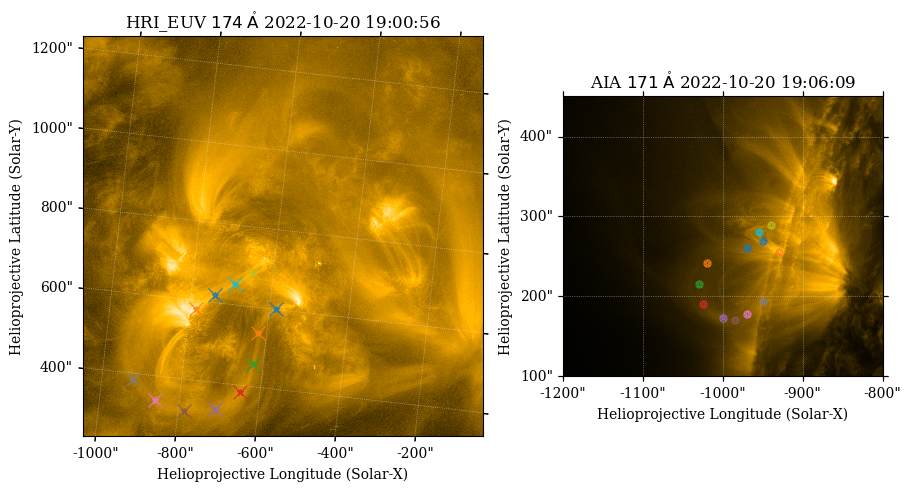

In [86]:
fig = plt.figure(figsize=(8,4))

ax1 = fig.add_axes([0,0,0.6,1],projection=hri_174_map_1020)
hri_174_map_1020.plot(axes=ax1)

ax2 = fig.add_axes([0.65,0,0.4,1],projection=aia_171_map_crop)
aia_171_map_crop.plot(axes=ax2,norm=ImageNormalize(stretch=AsinhStretch(0.5)))

for coords_hri_, color_ in zip(coords_hri,color_cycle):
    ax1.plot_coord(coords_hri_, marker="x", markersize=10,alpha=0.8,lw=0,color=color_)

for coords_aia_, color_ in zip(coords_aia,color_cycle):
    ax2.plot_coord(coords_aia_, marker="o", markersize=5,alpha=0.8,lw=0,markerfacecolor="none",color=color_)

most_probable_coords_hee = []
for coords_aia_, coords_hri_, color_ in zip(coords_aia_to_hri,coords_hri,color_cycle):
    most_probable_coord_hee_ = find_most_probable_hee_coord(aia_171_map_crop,hri_174_map_1020,coords_aia_,coords_hri_)
    most_probable_coords_hee.append(most_probable_coord_hee_)

for most_probable_coord_hee_, color_ in zip(most_probable_coords_hee,color_cycle):
    most_probable_coord_hee_hri = most_probable_coord_hee_.transform_to(hri_174_map_1020.coordinate_frame)

    with propagate_with_solar_surface(rotation_model="rigid"):
        most_probable_coord_hee_aia = most_probable_coord_hee_.transform_to(aia_171_map_crop.coordinate_frame)
    
    ax1.plot_coord(most_probable_coord_hee_hri, marker="*", markersize=5,alpha=0.8,lw=0,markerfacecolor="none",color=color_)
    ax2.plot_coord(most_probable_coord_hee_aia, marker="*", markersize=5,alpha=0.8,lw=0,markerfacecolor="none",color=color_)



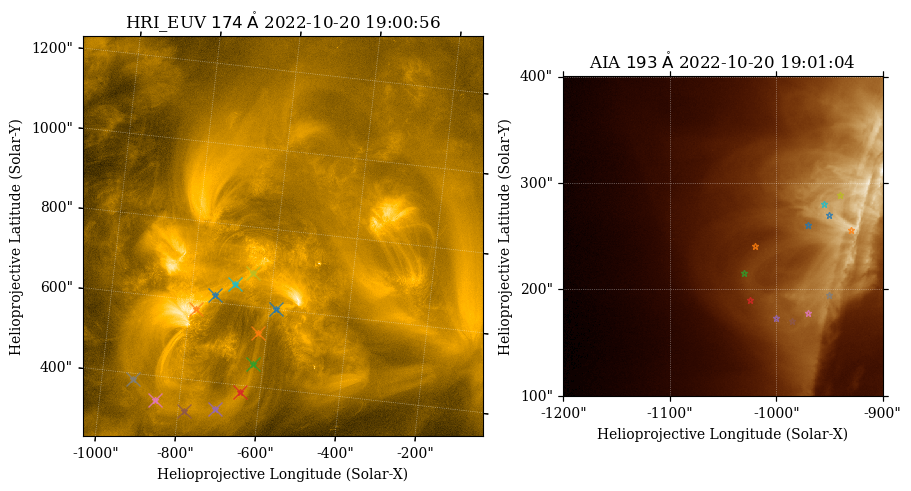

In [87]:
fig = plt.figure(figsize=(8,4))

ax1 = fig.add_axes([0,0,0.6,1],projection=hri_174_map_1020)
hri_174_map_1020.plot(axes=ax1)

ax2 = fig.add_axes([0.65,0,0.4,1],projection=aia_193_map_crop)
aia_193_map_crop.plot(axes=ax2,norm=ImageNormalize(stretch=AsinhStretch(0.2)))

for coords_hri_, color_ in zip(coords_hri,color_cycle):
    ax1.plot_coord(coords_hri_, marker="x", markersize=10,alpha=0.8,lw=0,color=color_)

for coords_aia_, color_ in zip(coords_aia,color_cycle):
    ax2.plot_coord(coords_aia_, marker="o", markersize=5,alpha=0.8,lw=0,markerfacecolor="none",color=color_)

most_probable_coords_hee = []
for coords_aia_, coords_hri_, color_ in zip(coords_aia_to_hri,coords_hri,color_cycle):
    most_probable_coord_hee_ = find_most_probable_hee_coord(aia_193_map_crop,hri_174_map_1020,coords_aia_,coords_hri_)
    most_probable_coords_hee.append(most_probable_coord_hee_)

for most_probable_coord_hee_, color_ in zip(most_probable_coords_hee,color_cycle):
    most_probable_coord_hee_hri = most_probable_coord_hee_.transform_to(hri_174_map_1020.coordinate_frame)

    with propagate_with_solar_surface(rotation_model="rigid"):
        most_probable_coord_hee_aia = most_probable_coord_hee_.transform_to(aia_193_map_crop.coordinate_frame)
    
    ax1.plot_coord(most_probable_coord_hee_hri, marker="*", markersize=5,alpha=0.8,lw=0,markerfacecolor="none",color=color_)
    ax2.plot_coord(most_probable_coord_hee_aia, marker="*", markersize=5,alpha=0.8,lw=0,markerfacecolor="none",color=color_)



/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/wcsaxes/patches.py:196: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


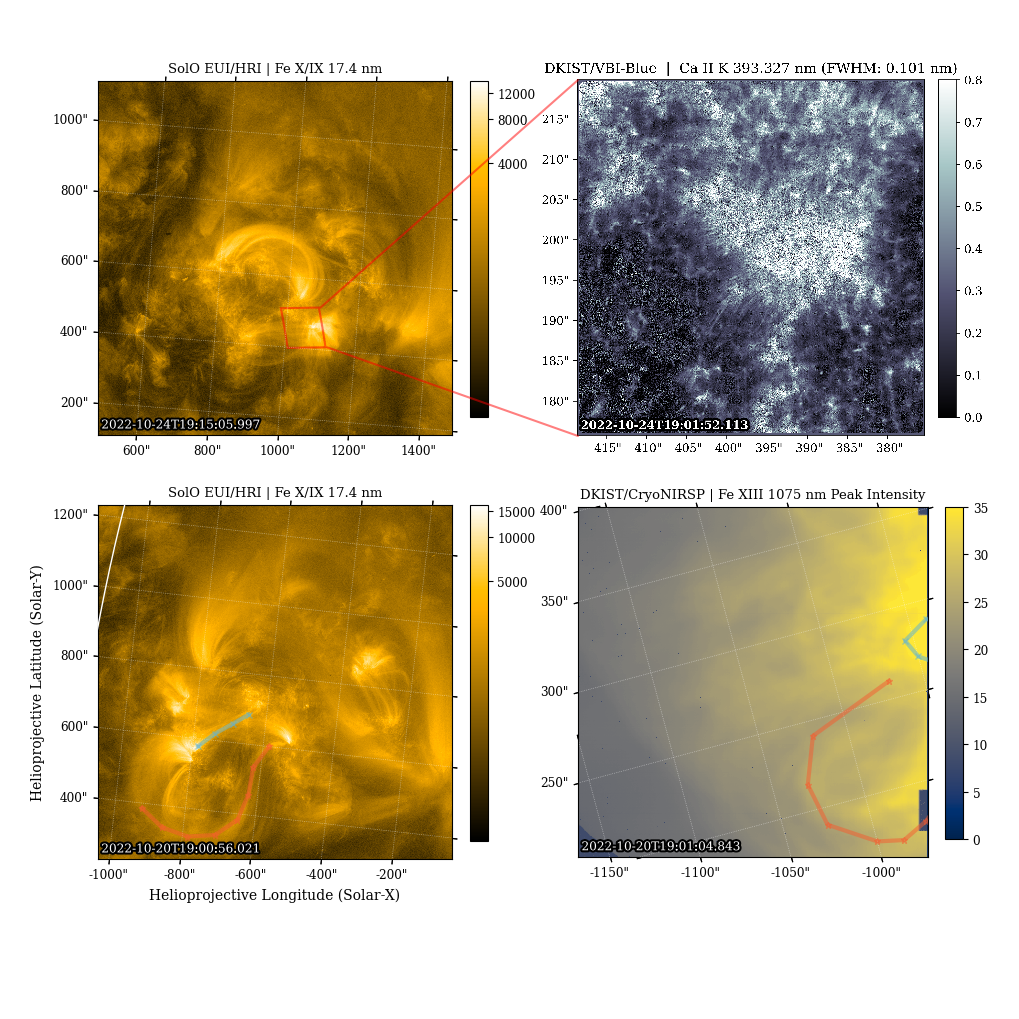

In [88]:
fig = plt.figure(figsize=(10, 10))



ax1 = fig.add_axes([0.065, 0.574, 0.4, 0.3545], projection=hri_174_map)
im1 = hri_174_map.plot(axes=ax1, title=False)
ax1.set_xlabel(' ')
ax1.set_ylabel(' ')
ax1.tick_params(labelsize=8.7)
ax1.set_title('SolO EUI/HRI | Fe X/IX 17.4 nm',fontsize=9.5)

clb1, clb_ax1 = plot_colorbar(im1,ax1,width="5%",bbox_to_anchor=(1.05, 0.05, 1, 1 - 0.05),fontsize=8.7)
with propagate_with_solar_surface(rotation_model="rigid"):
    aia_1600_map_eui_time.draw_quadrangle(vbi_bottom_left_coord, top_right=vbi_top_right_coord, axes=ax1, color="r", lw=1.5,alpha=0.5)

clb_ax1.set_zorder(-1)

ax1_time_text_obj = ax1.text(0.01,0.01, hri_174_map.date, transform=ax1.transAxes, fontsize=8.7, color="white",
                        ha="left", va="bottom")

ax1_time_text_obj.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])

clb_ax1.yaxis.set_major_locator(MaxNLocator(4))
clb_ax1.tick_params(axis="y",which="minor",right=False)

ax2 = fig.add_axes([0.5, 0.5, 0.5, 0.5])
ax2.set_zorder(-2)

ax2.imshow(vbi_CaIIK, cmap='gray')
ax2.axis('off')

reference_ax = fig.add_axes([0,0,1,1])
# reference_ax.set_zorder(15)


ax1.annotate('', xy=(vbi_top_right_coord_in_hri.Tx.to_value(u.deg), vbi_top_right_coord_in_hri.Ty.to_value(u.deg)), xytext=(0.568, 0.929),
            xycoords=ax1.get_transform("world"), textcoords=reference_ax.transAxes,
            arrowprops=dict(facecolor="red", edgecolor="red", arrowstyle='-', shrinkA=0, shrinkB=0,alpha=0.5,zorder=5,
            lw=1.5))

ax1.annotate('', xy=(vbi_bottom_right_coord_in_hri.Tx.to_value(u.deg), vbi_bottom_right_coord_in_hri.Ty.to_value(u.deg)), xytext=(0.568, 0.573),
            xycoords=ax1.get_transform("world"), textcoords=reference_ax.transAxes,
            arrowprops=dict(facecolor="red", edgecolor="red", arrowstyle='-', shrinkA=0, shrinkB=0,alpha=0.5,zorder=5,
            lw=1.5))

ax3 = fig.add_axes([0.065, 0.15, 0.4, 0.3545], projection=hri_174_map_1020)
im3 = hri_174_map_1020.plot(axes=ax3, title=False)
ax3.tick_params(labelsize=8.7)
ax3.set_title('SolO EUI/HRI | Fe X/IX 17.4 nm',fontsize=9.5)

ax3_time_text_obj = ax3.text(0.01,0.01, hri_174_map_1020.date, transform=ax3.transAxes, fontsize=8.7, color="white",
                        ha="left", va="bottom")
ax3_time_text_obj.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])

with propagate_with_solar_surface(rotation_model="rigid"):
    aia_171_map.draw_limb(axes=ax3)

clb3, clb_ax3 = plot_colorbar(im3,ax3,width="5%",bbox_to_anchor=(1.05, 0.05, 1, 1 - 0.05),fontsize=8.7)
clb_ax3.set_zorder(-1)
clb_ax3.yaxis.set_major_locator(MaxNLocator(4))
clb_ax3.tick_params(axis="y",which="minor",right=False)

ax3.plot_coord(astropy.coordinates.concatenate(most_probable_coords_hee)[:8], marker="*", markersize=5,alpha=0.5,lw=3,markerfacecolor="none",color="#F75C2F")
ax3.plot_coord(astropy.coordinates.concatenate(most_probable_coords_hee)[8:], marker="x", markersize=5,alpha=0.5,lw=3,markerfacecolor="none",color="#58B2DC")

ax4 = fig.add_axes([0.568, 0.15, 0.35, 0.3545],projection=cryo_NIRSP_1074_map)
ax4.set_zorder(-2)
im4 = cryo_NIRSP_1074_map.plot(axes=ax4, title=False,cmap="cividis")

ax4.set_xlabel(' ')
ax4.set_ylabel(' ')

ax4.tick_params(labelsize=8.7)
ax4.set_title(r'DKIST/CryoNIRSP | Fe XIII 1075 nm Peak Intensity',fontsize=9.5)

ax4_time_text_obj = ax4.text(0.01,0.01, cryo_NIRSP_1074_map.date, transform=ax4.transAxes, fontsize=8.7, color="white",
                        ha="left", va="bottom")
ax4_time_text_obj.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                          path_effects.Normal()])


clb4, clb_ax4 = plot_colorbar(im4,ax4,width="5%",bbox_to_anchor=(1.05, 0.05, 1, 1 - 0.05),fontsize=8.7)
# clb_ax4.set_zorder(0)
clb_ax4.yaxis.set_major_locator(MaxNLocator(8))
clb_ax4.tick_params(axis="y",which="minor",right=False)

bounds = ax4.axis()
with propagate_with_solar_surface(rotation_model="rigid"):
    with sunpy.coordinates.Helioprojective.assume_spherical_screen(cryo_NIRSP_1074_map.observer_coordinate,
                                             only_off_disk=True):
        ax4.plot_coord(astropy.coordinates.concatenate(most_probable_coords_hee)[:8], marker="*", markersize=5,alpha=0.5,lw=3,markerfacecolor="none",color="#F75C2F")
        ax4.plot_coord(astropy.coordinates.concatenate(most_probable_coords_hee)[8:], marker="x", markersize=5,alpha=0.5,lw=3,markerfacecolor="none",color="#58B2DC")
ax4.axis(bounds)


# reference_ax.yaxis.set_major_locator(MaxNLocator(100))
# reference_ax.xaxis.set_major_locator(MaxNLocator(100))
# reference_ax.grid("on",zorder=5)
# reference_ax.patch.set_alpha(0.2)


reference_ax.set_axis_off()
plt.savefig('../../figs/test_figs/issi_proposal_dkist_solo.png', dpi=300, bbox_inches=transforms.Bbox([[0.1,1],[9.8,9.5]]), pad_inches=0.0)
plt.savefig('../../figs/test_figs/issi_proposal_dkist_solo.pdf', dpi=300, bbox_inches=transforms.Bbox([[0.1,1],[9.8,9.5]]), pad_inches=0.0)

In [90]:
hri_174_map_wow = sunpy.map.Map(wow(hri_174_map.data,weights=[],bilateral=1, denoise_coefficients=[5, 2])[0],
                                hri_174_map.meta)
hri_174_map_1020_wow = sunpy.map.Map(wow(hri_174_map_1020.data,weights=[],bilateral=1, denoise_coefficients=[5, 2])[0],
                                hri_174_map_1020.meta)

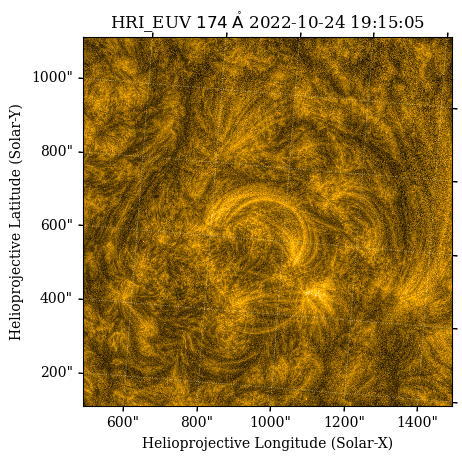

In [92]:
hri_174_map_wow.plot(norm=ImageNormalize())

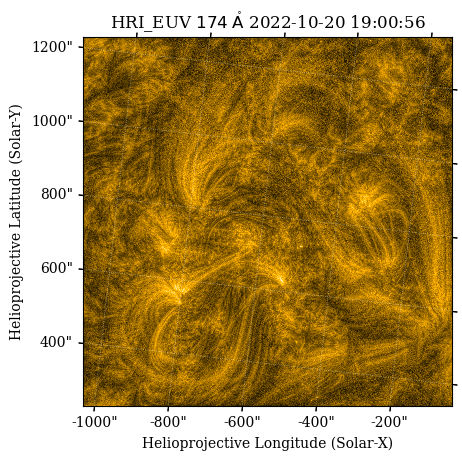

In [93]:
hri_174_map_1020_wow.plot(norm=ImageNormalize())